# 장비 충돌 및 고장 이상탐지

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.chdir("C:\\Users\\gw011\\OneDrive\\바탕 화면\\새 폴더\\chap3. Prac\\05. 장비충돌 및 고장 이상탐지")
os.getcwd()

'C:\\Users\\gw011\\OneDrive\\바탕 화면\\새 폴더\\chap3. Prac\\05. 장비충돌 및 고장 이상탐지'

## 문제상황 및 데이터 살펴보기

> 시나리오

A공장에서는 새로 도입한 장비의 지속적인 고장으로 인해 생산 스케줄이 지연되고 있다. 해당 장비의 특성상 한 번 고장이 나면 라인 전체를 stop 시켜야 하므로 공정 process에서 bottleneck 구간이다. 고장이 나면 공정상 막대한 손해이기 때문에 고장이 나기전 사전 이상징후를 포착하고 점검을 통해 고장이 발생하여 미치는 손실을 줄이고자 한다.

> 데이터 살펴보기

|Column|Description|
|:---|:---|
|id|센서id|
|Time|측정시간|
|S1|센서값1|
|S2|센서값2|
|S3|센서값3|
|S4|센서값4|

In [3]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)  

df_features = pd.read_csv('chapter27_abnormal_features.csv')
df_target = pd.read_csv('chapter27_abnormal_target.csv')

In [4]:
df_features.head()

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0


In [5]:
df_target.head()

,id,X,Y,M,V
0,0,0.0,-400.0,50.0,0.4
1,1,400.0,0.0,100.0,1.0
2,2,-300.0,-200.0,25.0,0.4
3,3,200.0,-100.0,150.0,0.4
4,4,-300.0,-100.0,150.0,0.4


- df_features dt에는 시간별 센서에서 수집되고 있는 S1~S4 값이 수집된다.
- df_target에는 장비에 최종적으로 전달된 M과 V가 기록되어 있다.

## 문제해결 프로세스 정의

> 문제정의

- 설비 고장으로 인한 Line stop, 생산 스케줄 지연, 매출감소, 영업이익 감소

> 기대효과

- 사전 이상징후 감지 및 점검을 통해 고장으로 인한 Line stop 감소, 생산 스케줄 정상화

> 성과측정

- 이상징후 모니터링 전/후 제품 생산량, line stop 횟수 비교

> 현업적용

- 실시간 센서 데이터 수집 및 DB 적재 시스템 구축
- 서버에 데이터 모델 탑재 및 특정 시간 단위 실행 및 결과 저장
- 결과 데이터 대시보드 및 BI 시스템에 출력 및 모니터링 

## 이상(abnormal) 정의 및 데이터 EDA 

In [6]:
print('df_features', df_features.shape)
print('df_target', df_target.shape)

df_features (1050000, 6)
df_target (2800, 5)


In [8]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050000 entries, 0 to 1049999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      1050000 non-null  int64  
 1   Time    1050000 non-null  float64
 2   S1      1050000 non-null  float64
 3   S2      1050000 non-null  float64
 4   S3      1050000 non-null  float64
 5   S4      1050000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 48.1 MB


In [9]:
print(df_features.isnull().sum())
print('')
print(df_target.isnull().sum())

id      0
Time    0
S1      0
S2      0
S3      0
S4      0
dtype: int64

id    0
X     0
Y     0
M     0
V     0
dtype: int64


In [10]:
print('df_features_unique_id :', len(df_features['id'].unique()))
print('df_target_unique_id :', len(df_target['id'].unique()))

df_features_unique_id : 2800
df_target_unique_id : 2800


In [11]:
df_features[df_features['id']==0].head(10)

# -> 하나의 ID당 0.000004초의 간격으로 센서 S1~S4에 값이 수집되고 있는 상황

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0
5,0,0.000020,0.0,0.0,0.0,0.0
6,0,0.000024,0.0,0.0,0.0,0.0
7,0,0.000028,0.0,0.0,0.0,0.0
8,0,0.000032,0.0,0.0,0.0,0.0
9,0,0.000036,0.0,0.0,0.0,0.0


In [12]:
# Target dataset과 차원을 맞춰주기 위해 id별로 sensor 값의 평균 이용
df_features_proc = df_features.groupby('id').mean()
df_features.groupby('id').mean()

,Time,S1,S2,S3,S4
id,,,,,
0,0.000748,-308.304553,-308.304553,1119.504719,1410.502893
1,0.000748,12780.176893,981.778780,7953.031214,-15584.755221
2,0.000748,-674.289628,-1575.681938,137.430228,-407.092340
3,0.000748,2164.216981,-11274.728589,-4221.738240,5241.350867
4,0.000748,-980.480585,-6966.912566,-2555.746810,5596.931287
...,...,...,...,...,...
2795,0.000748,5600.614397,5885.824925,-6380.192826,-7357.437798
2796,0.000748,-1215.328099,2702.879683,805.983784,-2876.150150
2797,0.000748,436.239993,276.327514,951.805606,-903.193922


In [13]:
print('df_features', df_features_proc.shape)
print('df_target', df_target.shape)

df_features (2800, 5)
df_target (2800, 5)


In [14]:
df_merge = pd.merge(df_features_proc, df_target, on='id', how='left')
df_merge.head(5)

,id,Time,S1,S2,S3,S4,X,Y,M,V
0,0,0.000748,-308.304553,-308.304553,1119.504719,1410.502893,0.0,-400.0,50.0,0.4
1,1,0.000748,12780.176893,981.778780,7953.031214,-15584.755221,400.0,0.0,100.0,1.0
2,2,0.000748,-674.289628,-1575.681938,137.430228,-407.092340,-300.0,-200.0,25.0,0.4
3,3,0.000748,2164.216981,-11274.728589,-4221.738240,5241.350867,200.0,-100.0,150.0,0.4
4,4,0.000748,-980.480585,-6966.912566,-2555.746810,5596.931287,-300.0,-100.0,150.0,0.4


In [15]:
# 전처리 완료된 최종 데이터셋!
df_merge = df_merge.drop(['Time', 'X', 'Y'], axis=1)
df_merge.head(5)

,id,S1,S2,S3,S4,M,V
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4


In [16]:
# m*v를 최종 충돌 에너지로 정의하고, 새로운 col을 생성함
df_merge['MV'] = df_merge['M'] * df_merge['V']
df_merge.head(5)

,id,S1,S2,S3,S4,M,V,MV
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0


충돌에너지 평균 : 60.0


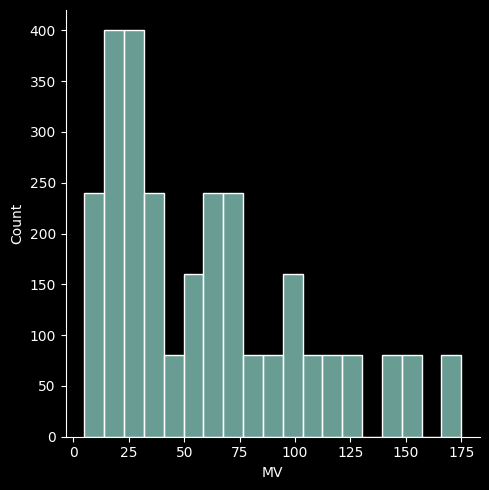

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

sns.displot(df_merge['MV']);
plt.gcf().set_size_inches(5, 5)
print("충돌에너지 평균 :", df_merge['MV'].mean())

In [18]:
# 이상을 정의하는 방법은 다양하고, 보통 현업에 기준이 존재할 확률이 큼
# 현업의 기준이 존재하지 않는다면, 보통 data의 평균에서 ±1, ±2, ±3 sd(표준편차) 떨어진 Data들을 이상으로 가정하는 경우가 많음
# mean + 2sd 이상인 충돌 에너지를 이상으로 정의
import numpy as np
df_merge['abnormal'] =  np.where(df_merge['MV'] > (df_merge['MV'].mean() + 2*df_merge['MV'].std()), 1, 0)
df_merge.head(5)

,id,S1,S2,S3,S4,M,V,MV,abnormal
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0,0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0,0
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0,0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0,0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0,0


In [20]:
df_merge['abnormal'].value_counts()

abnormal
0    2640
1     160
Name: count, dtype: int64

## 이상 발생 시점 분석

- 가설 : "이상 시점의 센서 데이터의 분포가 다를 것이다."

In [21]:
print("S1 abnormal :",df_merge[df_merge['abnormal']==1]['S1'].mean(), "/ normal : ",df_merge[df_merge['abnormal']==0]['S1'].mean())
print("S2 abnormal :",df_merge[df_merge['abnormal']==1]['S2'].mean(), "/ normal : ",df_merge[df_merge['abnormal']==0]['S2'].mean())
print("S3 abnormal :",df_merge[df_merge['abnormal']==1]['S3'].mean(), "/ normal : ",df_merge[df_merge['abnormal']==0]['S3'].mean())
print("S4 abnormal :",df_merge[df_merge['abnormal']==1]['S4'].mean(), "/ normal : ",df_merge[df_merge['abnormal']==0]['S4'].mean())

S1 abnormal : -910.6725618222317 / normal :  -374.457459218389
S2 abnormal : -910.6725618222324 / normal :  -374.45745931738884
S3 abnormal : -3662.427652993808 / normal :  -1193.247454043241
S4 abnormal : -4473.323652485669 / normal :  -1431.8663172477716


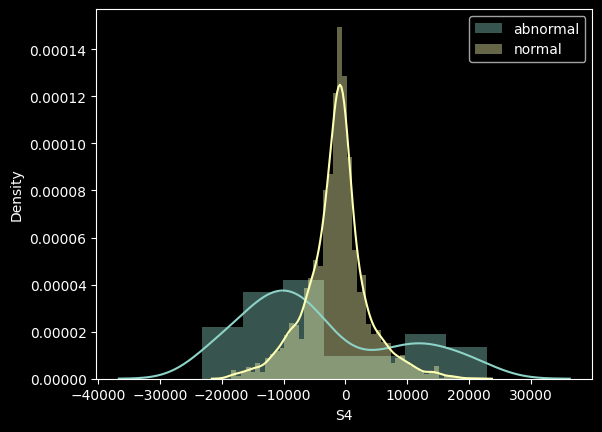

In [22]:
sns.distplot(df_merge[df_merge['abnormal']==1]['S4'], label='abnormal');
sns.distplot(df_merge[df_merge['abnormal']==0]['S4'], label='normal');
plt.legend();

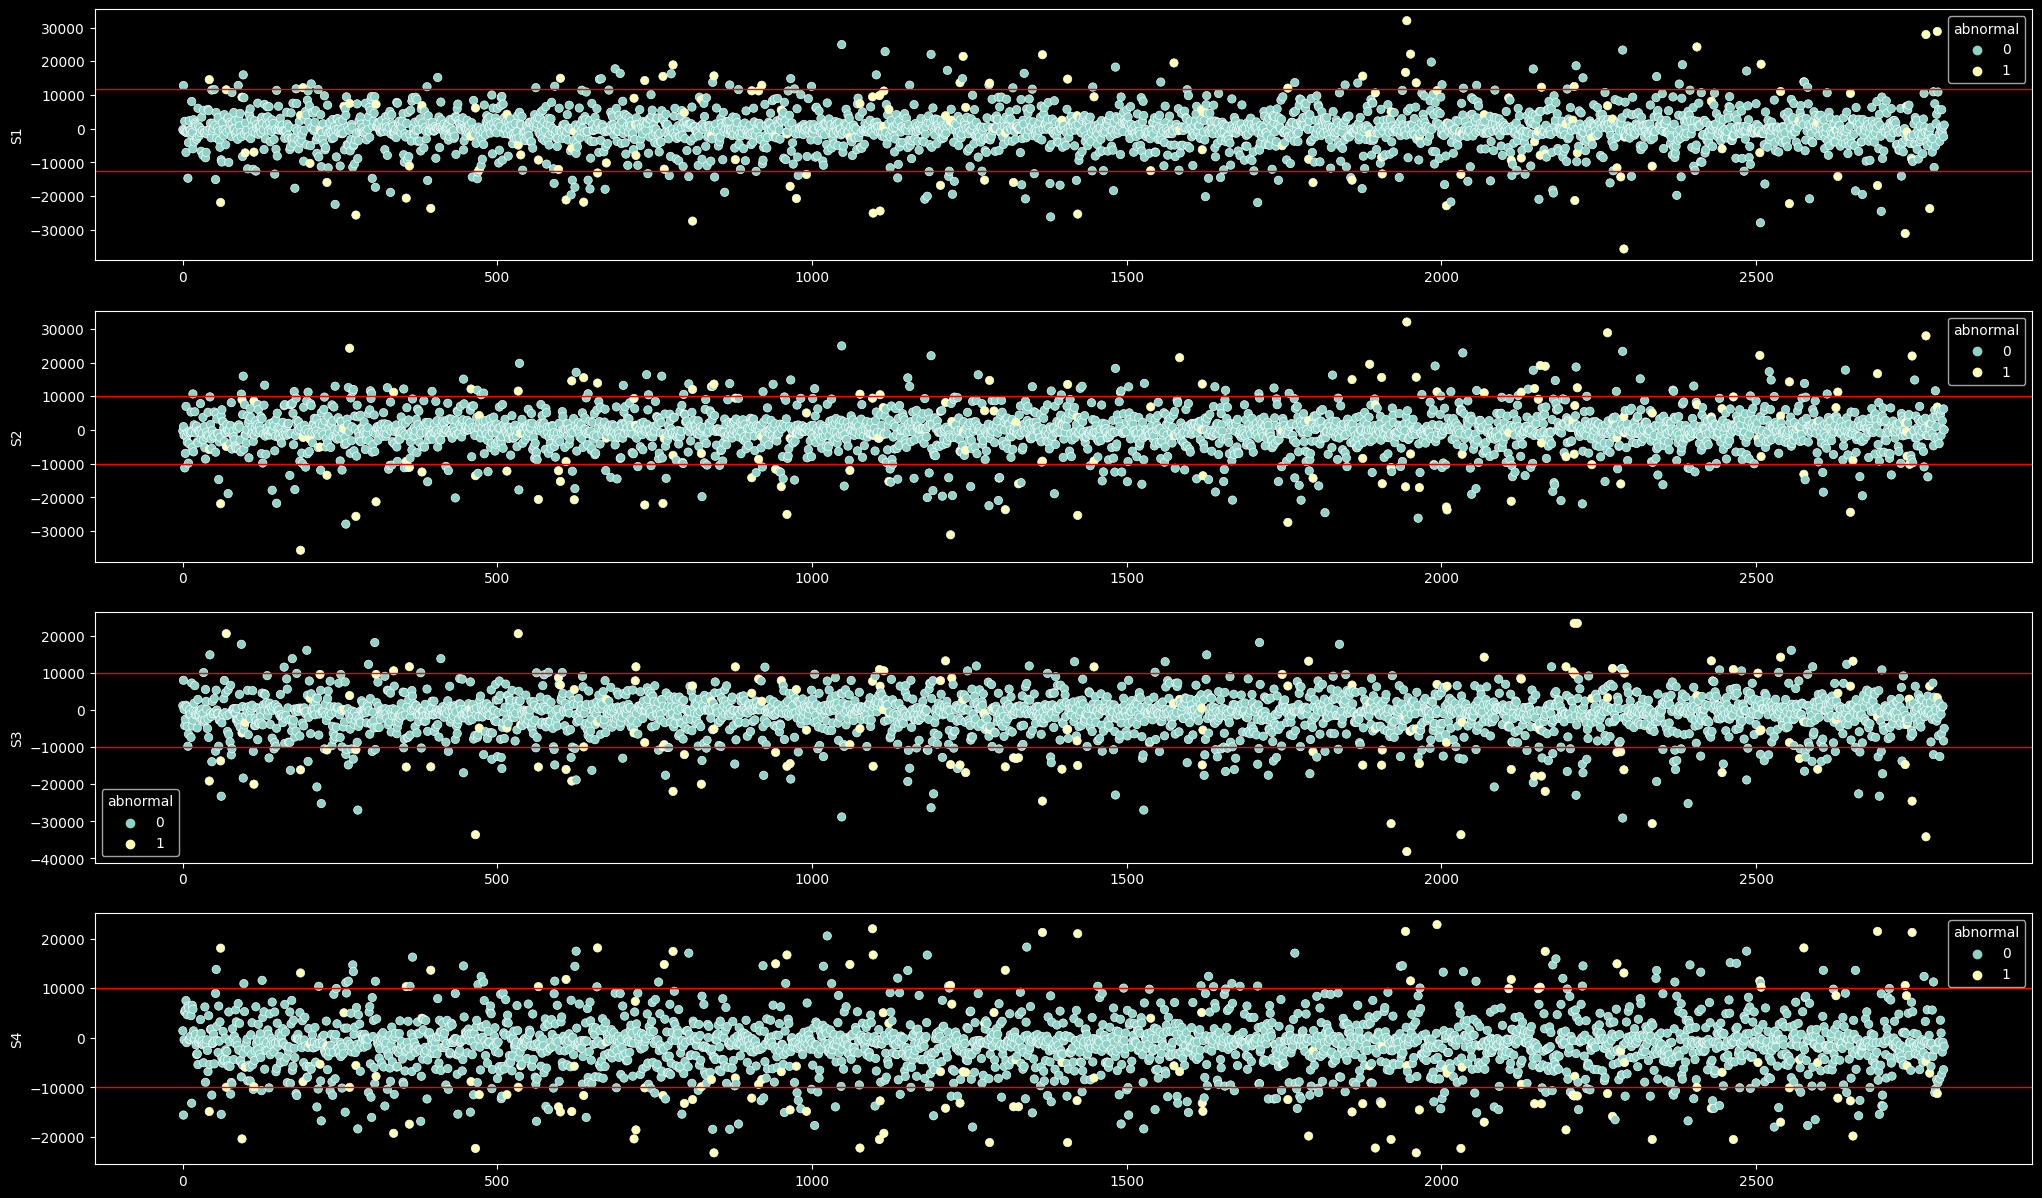

In [23]:
# 센서값이 중앙에서 멀어질수록 이상(노란색)이 더 많이 발생하고 있는 추세
fig, axes = plt.subplots(4, 1)
sns.scatterplot(x=df_merge.index, y=df_merge['S1'], hue = df_merge['abnormal'], ax=axes[0]);
sns.scatterplot(x=df_merge.index, y=df_merge['S2'], hue = df_merge['abnormal'], ax=axes[1]);
sns.scatterplot(x=df_merge.index, y=df_merge['S3'], hue = df_merge['abnormal'], ax=axes[2]);
sns.scatterplot(x=df_merge.index, y=df_merge['S4'], hue = df_merge['abnormal'], ax=axes[3]);

axes[0].axhline(y=df_merge['S1'].mean()+2*df_merge['S1'].std(), color='r', linewidth=1)
axes[0].axhline(y=df_merge['S1'].mean()-2*df_merge['S1'].std(), color='r', linewidth=1)

axes[1].axhline(y=10000, color='r', linewidth=1)
axes[1].axhline(y=-10000, color='r', linewidth=1)

axes[2].axhline(y=10000, color='r', linewidth=1)
axes[2].axhline(y=-10000, color='r', linewidth=1)

axes[3].axhline(y=10000, color='r', linewidth=1)
axes[3].axhline(y=-10000, color='r', linewidth=1)
plt.gcf().set_size_inches(25, 15)

- scatter plot을 통해 각 센서 값이 10000초과, -10000 미만일 때 더 많은 불량이 발생하는 것 확인.
- 실제 평균 이상률 6% 대비 더 많은 불량이 발생하는지 수치로 확인

In [28]:
# S1 불량률 확인
df_s1 = df_merge[(df_merge['S1'] > 10000) | (df_merge['S1'] < -10000)]
df_s1_abnormal_ratio = (len(df_s1[df_s1['abnormal']==1]) / len(df_s1)) * 100
print(f'{round(df_s1_abnormal_ratio,1)}%')
print(len(df_s1), len(df_s1[df_s1['abnormal']==1]))

27.0%
278 75


In [29]:
# S2 불량률 확인
df_s2 = df_merge[(df_merge['S2'] > 10000) | (df_merge['S2'] < -10000)]
df_s2_abnormal_ratio = (len(df_s2[df_s2['abnormal']==1]) / len(df_s2)) * 100
print(f'{round(df_s2_abnormal_ratio,1)}%')
print(len(df_s2), len(df_s2[df_s2['abnormal']==1]))

27.0%
278 75


In [30]:
# S3 불량률 확인
df_s3 = df_merge[(df_merge['S3'] > 10000) | (df_merge['S3'] < -10000)]
df_s3_abnormal_ratio = (len(df_s3[df_s3['abnormal']==1]) / len(df_s3)) * 100
print(f'{round(df_s3_abnormal_ratio,1)}%')
print(len(df_s3), len(df_s3[df_s3['abnormal']==1]))

28.6%
255 73


In [31]:
# S4 불량률 확인
df_s4 = df_merge[(df_merge['S4'] > 10000) | (df_merge['S4'] < -10000)]
df_s4_abnormal_ratio = (len(df_s4[df_s4['abnormal']==1]) / len(df_s4)) * 100
print(f'{round(df_s4_abnormal_ratio,1)}%')
print(len(df_s4), len(df_s4[df_s4['abnormal']==1]))

31.3%
300 94


In [32]:
# 상위의 인사이트를 활용하여 이상을 예측
# S1, S2, S3, S4가 10,000 초과, -10,000 미만 일시 이상으로 예측
df_merge['rule_base1'] = np.where( ((df_merge['S1'] > 10000) | (df_merge['S1'] < -10000)) , 1, 0)
df_merge['rule_base2'] = np.where( ((df_merge['S2'] > 10000) | (df_merge['S2'] < -10000)) , 1, 0)
df_merge['rule_base3'] = np.where( ((df_merge['S3'] > 10000) | (df_merge['S3'] < -10000)) , 1, 0)
df_merge['rule_base4'] = np.where( ((df_merge['S4'] > 10000) | (df_merge['S4'] < -10000)) , 1, 0)

In [33]:
df_merge.head(5)

,id,S1,S2,S3,S4,M,V,MV,abnormal,rule_base1,rule_base2,rule_base3,rule_base4
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0,0,0,0,0,0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0,0,1,0,0,1
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0,0,0,0,0,0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0,0,0,1,0,0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0,0,0,0,0,0


In [34]:
# ▶ presision : 예측한 것 중에 실제로 정답인 비율
# ▶ recall : 실제 정답중에서 예측으로 맞춘 비율
# ▶ S4 센서를 기준으로 이상을 예측 했을 때가 Best Score(recall 0.59)
from sklearn.metrics import classification_report
print(classification_report(df_merge['abnormal'], df_merge['rule_base1']))
print('--------------------------------------------------------')
print(classification_report(df_merge['abnormal'], df_merge['rule_base2']))
print('--------------------------------------------------------')
print(classification_report(df_merge['abnormal'], df_merge['rule_base3']))
print('--------------------------------------------------------')
print(classification_report(df_merge['abnormal'], df_merge['rule_base4']))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2640
           1       0.27      0.47      0.34       160

    accuracy                           0.90      2800
   macro avg       0.62      0.70      0.64      2800
weighted avg       0.93      0.90      0.91      2800

--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2640
           1       0.27      0.47      0.34       160

    accuracy                           0.90      2800
   macro avg       0.62      0.70      0.64      2800
weighted avg       0.93      0.90      0.91      2800

--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2640
           1       0.29      0.46      0.35       160

    accuracy                           0.90      2800
   macro avg  

## ML 활용 이상진단 및 예측

- 지도학습 -> RFC
- 비지도 학습 -> Isolation Forest

In [35]:
df_merge.head(5)

,id,S1,S2,S3,S4,M,V,MV,abnormal,rule_base1,rule_base2,rule_base3,rule_base4
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0,0,0,0,0,0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0,0,1,0,0,1
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0,0,0,0,0,0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0,0,0,1,0,0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0,0,0,0,0,0


In [36]:
# 모델링을 학습하기 위한 Fearue(X)와 Y데이터를 구분하는 단계 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X=df_merge.drop(['id', 'M', 'V', 'MV', 'rule_base1', 'rule_base2', 'rule_base3', 'rule_base4', 'abnormal'], axis=1)
Y=df_merge['abnormal']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state = 123456)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1960, 4)
(1960,)
(840, 4)
(840,)


In [37]:
rfc = RandomForestClassifier(random_state=123456)
rfc.fit(x_train, y_train)

# 예측은 학습에 사용된 Data와 Test Data 모두 예측하고 평가함(※ 과적합 여부 판별)
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1848
           1       1.00      1.00      1.00       112

    accuracy                           1.00      1960
   macro avg       1.00      1.00      1.00      1960
weighted avg       1.00      1.00      1.00      1960

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       792
           1       0.75      0.62      0.68        48

    accuracy                           0.97       840
   macro avg       0.86      0.81      0.83       840
weighted avg       0.96      0.97      0.97       840



In [38]:
# 모델 성능을 올리기 위한 하이퍼 파라미터 튜닝 
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [400, 500],
           'max_depth' : [6, 8, 10, 12]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 123456, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1, scoring='recall')
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도(recall): {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 12, 'n_estimators': 400}
최고 예측 정확도(recall): 0.4011


In [39]:
# Best score 파라미터로 다시 재학습
rfc = RandomForestClassifier(n_estimators=400, max_depth=8, random_state = 123456)
rfc.fit(x_train, y_train)

# 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1848
           1       1.00      0.66      0.80       112

    accuracy                           0.98      1960
   macro avg       0.99      0.83      0.89      1960
weighted avg       0.98      0.98      0.98      1960

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       792
           1       0.73      0.46      0.56        48

    accuracy                           0.96       840
   macro avg       0.85      0.72      0.77       840
weighted avg       0.95      0.96      0.96       840



In [40]:
pd.Series(y_pred_train).value_counts()

0    1886
1      74
Name: count, dtype: int64

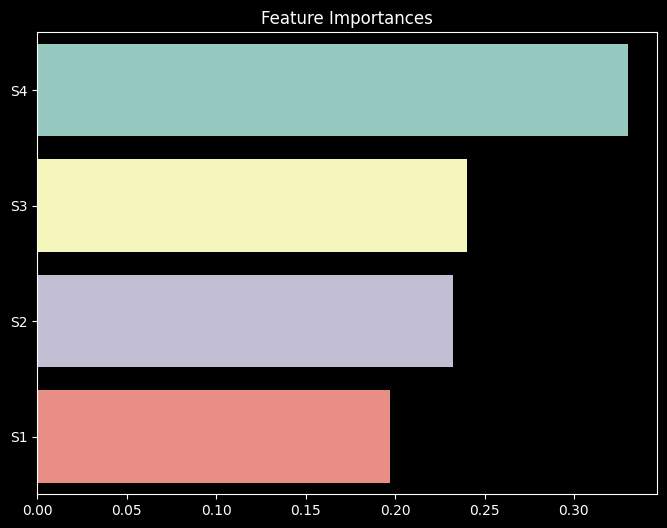

In [41]:
## 중요 변수 파악
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()

In [43]:
# 모델 성능 위한 추가 변수 탐색
df_new=df_merge.copy()

# ▶ 제곱
df_new['S1_2']=df_new['S1']*df_new['S1']
df_new['S2_2']=df_new['S2']*df_new['S2']
df_new['S3_2']=df_new['S3']*df_new['S3']
df_new['S4_2']=df_new['S4']*df_new['S4']

# ▶ 곱셈
df_new['s1*s2']=df_new['S1']*df_new['S2']
df_new['s2*s3']=df_new['S2']*df_new['S3']
df_new['s3*s4']=df_new['S3']*df_new['S4']
df_new['s1*s4']=df_new['S1']*df_new['S4']

df_new.head(5)

,id,S1,S2,S3,S4,M,V,MV,abnormal,rule_base1,rule_base2,rule_base3,rule_base4,S1_2,S2_2,S3_2,S4_2,s1*s2,s2*s3,s3*s4,s1*s4
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0,0,0,0,0,0,9.505170e+04,9.505170e+04,1.253291e+06,1.989518e+06,9.505170e+04,-3.451484e+05,1.579065e+06,-4.348645e+05
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0,0,1,0,0,1,1.633329e+08,9.638896e+05,6.325071e+07,2.428846e+08,1.254731e+07,7.808117e+06,-1.239460e+08,-1.991759e+08
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0,0,0,0,0,0,4.546665e+05,2.482774e+06,1.888707e+04,1.657242e+05,1.062466e+06,-2.165463e+05,-5.594679e+04,2.744981e+05
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0,0,0,1,0,0,4.683835e+06,1.271195e+08,1.782307e+07,2.747176e+07,-2.440096e+07,4.759895e+07,-2.212761e+07,1.134342e+07
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0,0,0,0,0,0,9.613422e+05,4.853787e+07,6.531842e+06,3.132564e+07,6.830923e+06,1.780566e+07,-1.430434e+07,-5.487682e+06


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X=df_new.drop(['id', 'M', 'V', 'MV', 'rule_base1', 'rule_base2', 'rule_base3', 'rule_base4', 'abnormal'], axis=1)
Y=df_new['abnormal']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state = 123456)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1960, 12)
(1960,)
(840, 12)
(840,)


In [45]:
rfc = RandomForestClassifier(n_estimators=400, max_depth=8, random_state=123456)
rfc.fit(x_train, y_train)

# 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1848
           1       1.00      0.71      0.83       112

    accuracy                           0.98      1960
   macro avg       0.99      0.85      0.91      1960
weighted avg       0.98      0.98      0.98      1960

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       792
           1       0.86      0.50      0.63        48

    accuracy                           0.97       840
   macro avg       0.91      0.75      0.81       840
weighted avg       0.96      0.97      0.96       840



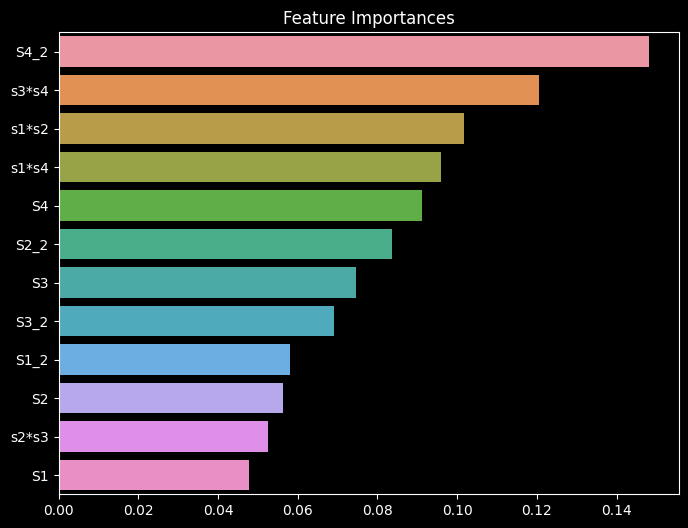

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [48]:
# Isolation Forest 비교 분석
from sklearn.ensemble import IsolationForest

# ▶ 학습
clf = IsolationForest(max_samples=100, contamination = 0.06, random_state=123456)
clf.fit(x_train)

# ▶ 예측
y_pred_test = clf.predict(x_test)

In [49]:
y_pred_test = np.where(y_pred_test==-1, 1, 0)
y_pred_test[0:5]

array([0, 0, 0, 0, 0])

In [50]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       792
           1       0.55      0.54      0.55        48

    accuracy                           0.95       840
   macro avg       0.76      0.76      0.76       840
weighted avg       0.95      0.95      0.95       840



In [51]:
pd.Series(y_pred_test).value_counts()

0    793
1     47
Name: count, dtype: int64